# Training species classifier Expt 3: cross-validation of Oswald data
# Mar 23, 2021: LSTM
# Replace categorical cross-entropy by binary cross-entropy
## Spatial Pyramid Pooling (SPP): [1, 1], [1, 2], [1, 4], [1, 8]
## The augemented noise is from the all five deployments.
## Trained on PICEAS2005 & STAR2000 whereas tested on HICEAS2002, STAR2003 & STAR2006

In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, Concatenate, LSTM, Reshape, Lambda, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy  # CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow_addons.layers.spatial_pyramid_pooling as spp
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Hyper parameters
# learning_rate = 1.0e-3
conv_dim = 16
rnn_dim = 16
pool_size = 2
pool_stride = 1  # stride over time
l2_regu = 0.0000
drop_rate = 0.2
hidden_units = 128
fcn_dim = 128

# learning_rate = 1.e-4
# conv_dim = 64
# rnn_dim = 16
# pool_size = 2
# pool_stride = 2
# l2_regu = 0.00
# drop_rate = 0.2
# # drop_rate = 0.5
# hidden_units = 512
# fcn_dim = 512

num_epoch = 400
# batch_size = 128
batch_size = 64  # rnn
# batch_size = 32  # for cnn14+attention
# batch_size = 16  # for cnn14+spp

num_patience = 10

In [4]:
# boundaries = [20, 40, 60, 80]
boundaries = [num_epoch, 10200, 10300, 10400]
# values = [1.0e-3, 3.33e-4, 1.0e-4, 3.33e-5, 1.0e-5]
values = [3.33e-3, 1.0e-3, 3.33e-4, 1.0e-4, 3.33e-5]
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

In [5]:
# data_type_dict = {1: 'universal', 2: 'file', 3: 'encounter', 4: 'domain'}
# data_type = 2

work_path = '/home/ys587/__Data/__whistle/__whislte_30_species'
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
feature_path = os.path.join(work_path, '__dataset/20210210')

In [6]:
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
num_species = len(species_dict)
# species_dict = {'BD': 0, 'MH': 1, 'CD': 2, 'STR': 3, 'SPT': 4, 'SPIN': 5, 'PLT': 6, 'RD': 7, 'RT': 8,
#                 'WSD': 9, 'FKW': 10, 'BEL': 11, 'KW': 12, 'WBD': 13, 'DUSK': 14, 'FRA': 15, 'PKW': 16, 'LPLT': 17,
#                 'CLY': 18, 'SPE': 19, 'ASP': 20}
species_list = list(species_dict.keys())
species_id = list(species_dict.values())

## Combine features

In [7]:
deployment = ['STAR2000', 'STAR2003', 'STAR2006', 'HICEAS2002', 'PICEAS2005']  # oswald_STAR2000_orig.npz, oswald_STAR2000_aug.npz
feature_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210223_augment_all_three_noise_mixed'
# feature_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210308_augment_all_three_noise_mixed_class_balanced_min_5'


In [8]:
if False:
    for ee in deployment:
        print(ee)
        ee_others = [ee2 for ee2 in deployment if (ee2 != ee) ]
        fea_train_files_tot = []
        for ee2 in ee_others:
            fea_train_files_tot.append('oswald_'+ee2+'_orig.npz')
            fea_train_files_tot.append('oswald_'+ee2+'_aug.npz')

        # Training data
        fea_train_list = []
        label_train_list = []
        for ii in range(len(fea_train_files_tot)):
            ff = fea_train_files_tot[ii]
            print(ff)
            fea_temp = np.load(os.path.join(feature_path, ff))
            print(fea_temp.files)

            if ii == 0:
                fea_train = fea_temp['feas_orig']
                label_train = fea_temp['labels_orig']
                print(fea_train.shape)
                print(label_train.shape)
            elif ii % 2 == 0:  # even
                fea_train = np.concatenate([fea_train, fea_temp['feas_orig']])
                label_train = np.concatenate([label_train, fea_temp['labels_orig']])
                print(fea_train.shape)
                print(label_train.shape)
            else:
                fea_train = np.concatenate([fea_train, fea_temp['feas_aug']])
                label_train = np.concatenate([label_train, fea_temp['labels_aug']])
                print(fea_train.shape)
                print(label_train.shape)
        print(fea_train.shape)
        print(label_train.shape)
        np.savez(os.path.join(feature_path, './train_oswald_no_'+ee+'.npz'), fea_train=fea_train, label_train=label_train)
        print('')

In [9]:
# data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, feature, label, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.X = feature
        self.X_dim = len(feature.shape)
        self.y = to_categorical(label, num_classes)
        self.indices = np.arange(self.y.shape[0])
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # self.index = np.arange(len(self.indices))
        #self.df = dataframe
        #self.indices = self.df.index.tolist()        
        # self.x_col = x_col
        # self.y_col = y_col
        
        self.on_epoch_end()

    def __len__(self):
        return int(floor(len(self.indices)/self.batch_size))
        # return label.shape[0]

    def __getitem__(self, index):
        # index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # batch = [self.indices[k] for k in index]
        batch = list(range(index*self.batch_size, (index+1)*self.batch_size))
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        y = np.zeros((self.batch_size, self.y.shape[1]))
        
        if self.X_dim == 3:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2]))
            for i, id in enumerate(batch):
                X[i,:, :] = self.X[id, :, :]  # logic
                y[i, :] = self.y[id, :] # labels
                
        elif self.X_dim == 4:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2], self.X.shape[3]))
            for i, id in enumerate(batch):
                X[i,:, :, :] = self.X[id, :, :, :]  # logic
                y[i, :] = self.y[id, :] # labels

        return X, y

## Models

In [10]:
# RNN / LSTM 
def model_conv_lstm(time_steps, freq_bins, classes_num, conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
#     # group 4 
#     y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
#     y = BatchNormalization()(y)
#     y = Activation(activation='relu')(y)
#     y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
#     y = BatchNormalization()(y)
#     y = Activation(activation='relu')(y)
#     y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
#     y = Dropout(drop_rate)(y)

#     # group 5
#     y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
#     y = BatchNormalization()(y)
#     y = Activation(activation='relu')(y)
#     y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
#     y = BatchNormalization()(y)
#     y = Activation(activation='relu')(y)

    
#     dim_cnn = K.int_shape(y)
#     y = spp.SpatialPyramidPooling2D(bins=[[time_steps, 1], [time_steps, 2], [time_steps, 4]], data_format='channels_last')(y)
#     y = Reshape((time_steps, 7*dim_cnn[3]))(y)
    
    dim_cnn = K.int_shape(y)
    y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)
    
    # y = Reshape(time_steps, 7, )(y)
    # dim_spp = K.int_shape(y)
    # y = Reshape((dim_spp[1]*dim_spp[2], ))(y)
    # dim_cnn = K.int_shape(y)
    # y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)
    
    
    #y = LSTM(hidden_units, activation='relu', return_sequences=True, dropout=drop_rate, recurrent_dropout=drop_rate)(y)
    #y = LSTM(hidden_units, activation='relu', dropout=drop_rate, recurrent_dropout=drop_rate)(y)
    y = GRU(hidden_units, activation='relu', return_sequences=True, dropout=drop_rate)(y)
    y = GRU(hidden_units, activation='relu')(y)
    x = Dense(classes_num, activation='sigmoid')(y)

#     # FC block
#     a1 = Dense(hidden_units)(y)
#     a1 = BatchNormalization()(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Dropout(drop_rate)(a1)

#     a2 = Dense(hidden_units)(a1)
#     a2 = BatchNormalization()(a2)
#     a2 = Activation('relu')(a2)
#     a2 = Dropout(drop_rate)(a2)

#     a3 = Dense(hidden_units)(a2)
#     a3 = BatchNormalization()(a3)
#     a3 = Activation('relu')(a3)
#     a3 = Dropout(drop_rate)(a3)
    
#     y = Dense(hidden_units, activation='relu', name='cnn14_fcn')(y)  # original 512
#      y = Dense(hidden_units, activation='relu', name='cnn14_fcn2')(y)  # original 512
    # x = Dense(classes_num, activation='softmax')(y)
#     x = Dense(classes_num, activation='sigmoid')(y)
    # x = Dense(classes_num, activation='sigmoid')(a3)
    
    # Build model
    model = Model(inputs=input_layer, outputs=x)
    
    return model

# Model compile, class weight & fitting

In [11]:
# def find_best_model(model_folder, remove_others=False):
#     model_list = glob.glob(model_folder+'/*.hdf5')
#     model_list.sort()
#     the_best_model = model_list[-1]
    
#     if remove_others==True:
#         for mm in model_list[:-1]:
#             os.remove(mm)
            
#     print(the_best_model)
    
#     return the_best_model
import re

def find_best_model(classifier_path, fmt='epoch_\d+_valloss_(\d+.\d{4})_valacc_(\d+.\d{4}).hdf5', is_max=True, purge=True):
    """
    Return the path to the model with the best accuracy, given the path to
    all the trained classifiers
    Args:
        classifier_path: path to all the trained classifiers
        fmt: e.g. "epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5"
        'epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5'
        is_max: use max; otherwise, min
        purge: True to purge models files except the best one
    Return:
        the path of the model with the best accuracy
    """
    # list all files ending with .hdf5
    day_list = sorted(glob.glob(os.path.join(classifier_path + '/', '*.hdf5')))

    # re the last 4 digits for accuracy
    hdf5_filename = []
    hdf5_accu = np.zeros(len(day_list))
    for dd in range(len(day_list)):
        filename = os.path.basename(day_list[dd])
        hdf5_filename.append(filename)
        # m = re.search("_F1_(0.\d{4}).hdf5", filename)
        # m = re.search("_([0-1].\d{4}).hdf5", filename)
        # m = re.search("epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5", filename)
        m = re.search(fmt, filename)
        try:
            #  hdf5_accu[dd] = float(m.groups()[0])
            hdf5_accu[dd] = float(m.groups()[1])
        except:
            continue

    # select the laregest one and write to the variable classifier_file
    if len(hdf5_accu) == 0:
        best_model_path = ''
        best_accu = 0
    else:
        if is_max is True:
            ind_max = np.argmax(hdf5_accu)
        else: # use min instead
            ind_max = np.argmin(hdf5_accu)
        best_model_path = day_list[int(ind_max)]
        best_accu = hdf5_accu[ind_max]
        # purge all model files except the best_model
        if purge:
            for ff in day_list:
                if ff != best_model_path:
                    os.remove(ff)
    print('Best model:'+str(best_accu))
    print(best_model_path)
    return best_model_path, best_accu


In [12]:
### cnn4 + attention
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_max_pooling', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_multi_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# vggish
# model = model_vggish(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim)

# cnn10
# model = model_cnn10(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14
# model = model_cnn14(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14 attention
# model = model_cnn14_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_bigru_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, rnn_dim=rnn_dim, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)

# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = CategoricalCrossentropy()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])



# Cross validation

In [13]:
today = datetime.now()
# create a folder based on date & time
fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))

## STAR2000

In [14]:
ee = deployment[0]
print(ee)

STAR2000


In [15]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

fea_train = fea_train[:,:100,:]
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [16]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [17]:
Counter(label_train_list)

Counter({'BD': 10740,
         'CD': 4656,
         'FKW': 19080,
         'SPIN': 3264,
         'SPT': 8556,
         'STR': 8352,
         'PLT': 11856,
         'RT': 7410})

In [18]:
Counter(label_test.tolist())

Counter({0.0: 121, 1.0: 3964, 5.0: 31, 6.0: 76, 4.0: 491, 3.0: 845, 2.0: 1140})

In [19]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [20]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (73914, 100, 128)
feature test shape: (6668, 100, 128)
label train shape: (73914,)
label test shape: (6668,)
dim_time: 100
dim_freq: 128


In [21]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [22]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [23]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [24]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.10, random_state=42+4)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [25]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_conv_lstm(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = categorical_crossentropy
loss = binary_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128, 16)      0     

In [26]:
# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

Epoch 1/400
1039/1039 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.2333
Epoch 00001: val_accuracy improved from -inf to 0.34185, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2000/epoch_01_valloss_0.3254_valacc_0.3418.hdf5
1039/1039 [==============================] - 267s 257ms/step - loss: 0.3541 - accuracy: 0.2333 - val_loss: 0.3254 - val_accuracy: 0.3418
Epoch 2/400
1039/1039 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.4178
Epoch 00002: val_accuracy improved from 0.34185 to 0.44321, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2000/epoch_02_valloss_0.2836_valacc_0.4432.hdf5
1039/1039 [==============================] - 266s 256ms/step - loss: 0.3009 - accuracy: 0.4178 - val_loss: 0.2836 - val_accuracy: 0.4432
Epoch 3/400
1039/1039 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.4860
Ep

In [27]:
# fit_result_path2 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210310_095616/STAR2000'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.6568
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2000/epoch_23_valloss_0.1926_valacc_0.6568.hdf5


In [28]:
model = load_model(the_best_model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128, 16)      0     

In [29]:
# testing
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [30]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [31]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  39   23    5   28    2    6   13    5]
 [ 732 1992  270  376   91  343  154    6]
 [ 314  266  142  247   40   86   31   14]
 [ 106  376    9  202   12  122   15    3]
 [ 234   38   25  110   73    8    2    1]
 [   0    0    0    0    0   29    0    2]
 [  16    4    8    3    0    6   38    1]
 [   0    0    0    0    0    0    0    0]]

[[0.32 0.19 0.04 0.23 0.02 0.05 0.11 0.04]
 [0.18 0.5  0.07 0.09 0.02 0.09 0.04 0.  ]
 [0.28 0.23 0.12 0.22 0.04 0.08 0.03 0.01]
 [0.13 0.44 0.01 0.24 0.01 0.14 0.02 0.  ]
 [0.48 0.08 0.05 0.22 0.15 0.02 0.   0.  ]
 [0.   0.   0.   0.   0.   0.94 0.   0.06]
 [0.21 0.05 0.11 0.04 0.   0.08 0.5  0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [32]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

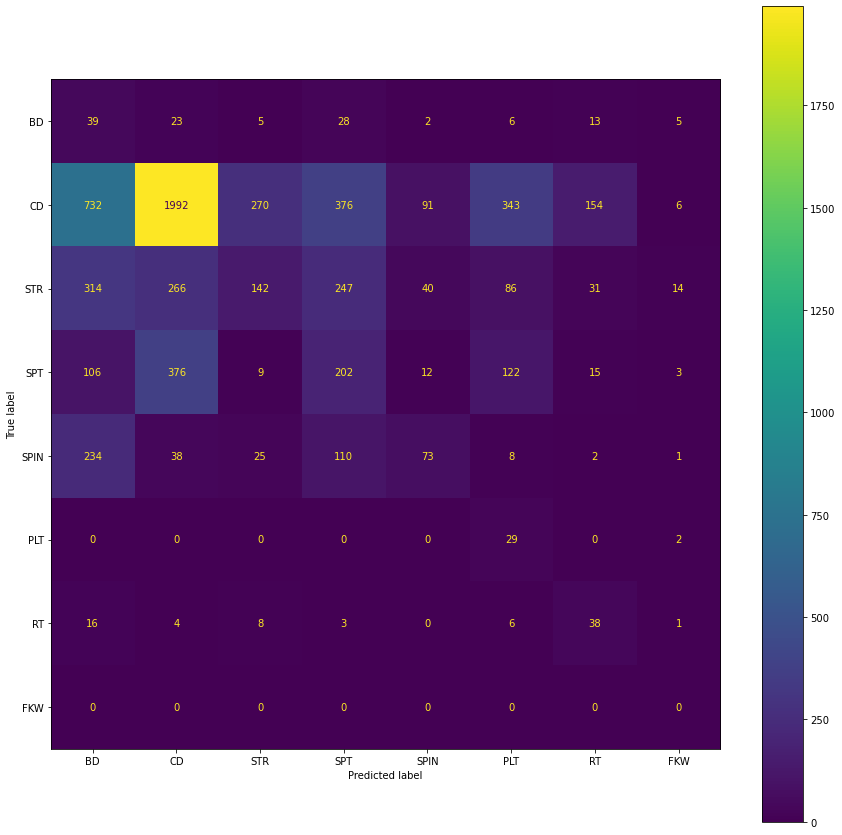

In [33]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


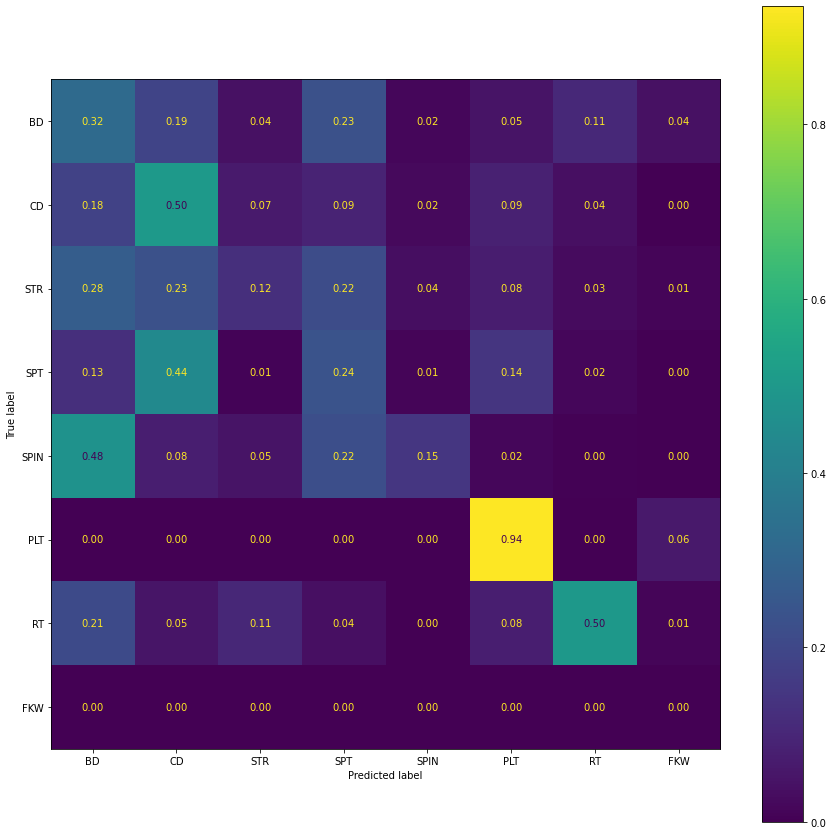

In [34]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## top k accuracy score

In [35]:
from sklearn.metrics import top_k_accuracy_score

In [36]:
top_k = []
for kk in range(1, num_species+1):
    print('k='+str(kk)+':  ')
    this_acc = top_k_accuracy_score(label_test, label_pred, k=kk, labels=list(range(num_species)))
    print(this_acc)
    top_k.append(this_acc)

k=1:  
0.3771745650869826
k=2:  
0.5487402519496101
k=3:  
0.6985602879424115
k=4:  
0.8165866826634673
k=5:  
0.9251649670065987
k=6:  
0.9646070785842832
k=7:  
0.987252549490102
k=8:  
1.0


/home/ys587/miniconda3/envs/whistle_classifier/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1693: UndefinedMetricWarning: 'k' (8) greater than or equal to 'n_classes' (8) will result in a perfect score and is therefore meaningless.
  warnings.warn(


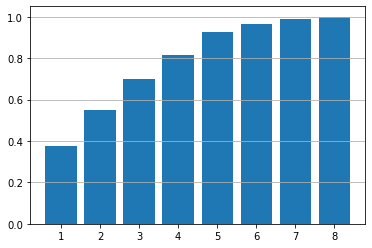

In [37]:
# %matplotlib inline
fig = plt.figure()
ax = fig.subplots()
ax.bar(list(range(1, num_species+1)), top_k)
ax.grid(axis='y')

## average_precision_score

## STAR2003

In [38]:
ee = deployment[1]
print(ee)

STAR2003


In [39]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [40]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [41]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [42]:
fea_train = fea_train[:,:100,:]

In [43]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [44]:
Counter(label_train_list)

Counter({'BD': 10080,
         'CD': 23928,
         'PLT': 12042,
         'RT': 7866,
         'SPIN': 5904,
         'SPT': 11154,
         'STR': 14868,
         'FKW': 17460})

In [45]:
Counter(label_test.tolist())

Counter({0.0: 231, 1.0: 752, 7.0: 270, 4.0: 51, 3.0: 412, 2.0: 54})

In [46]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [47]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (103302, 100, 128)
feature test shape: (1770, 100, 128)
label train shape: (103302,)
label test shape: (1770,)
dim_time: 100
dim_freq: 128


In [48]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [49]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [50]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [51]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.10, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [52]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_conv_lstm(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = CategoricalCrossentropy()
loss = binary_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

Epoch 1/400
1452/1452 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.2703
Epoch 00001: val_accuracy improved from -inf to 0.40518, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2003/epoch_01_valloss_0.2921_valacc_0.4052.hdf5
1452/1452 [==============================] - 373s 257ms/step - loss: 0.3433 - accuracy: 0.2703 - val_loss: 0.2921 - val_accuracy: 0.4052
Epoch 2/400
1452/1452 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.4450
Epoch 00002: val_accuracy improved from 0.40518 to 0.50330, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2003/epoch_02_valloss_0.2534_valacc_0.5033.hdf5
1452/1452 [==============================] - 372s 256ms/step - loss: 0.2864 - accuracy: 0.4450 - val_loss: 0.2534 - val_accuracy: 0.5033
Epoch 3/400
1452/1452 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.5191
Ep

In [53]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.6741
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2003/epoch_64_valloss_0.1810_valacc_0.6741.hdf5


In [54]:
model = load_model(the_best_model)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_6 (Activation)    (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_7 (Activation)    (None, 100, 128, 16)      0   

In [55]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [56]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [57]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[ 18   6 103  57  22  10  14   1]
 [ 27 219 273 116   9  65  33  10]
 [  0   2  30   5   1   3  10   3]
 [  2  35 211 108   2  47   5   2]
 [  1   1  15  22   8   0   2   2]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   1   1   2  21  55 190]]

[[0.08 0.03 0.45 0.25 0.1  0.04 0.06 0.  ]
 [0.04 0.29 0.36 0.15 0.01 0.09 0.04 0.01]
 [0.   0.04 0.56 0.09 0.02 0.06 0.19 0.06]
 [0.   0.08 0.51 0.26 0.   0.11 0.01 0.  ]
 [0.02 0.02 0.29 0.43 0.16 0.   0.04 0.04]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.01 0.08 0.2  0.7 ]]


In [58]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

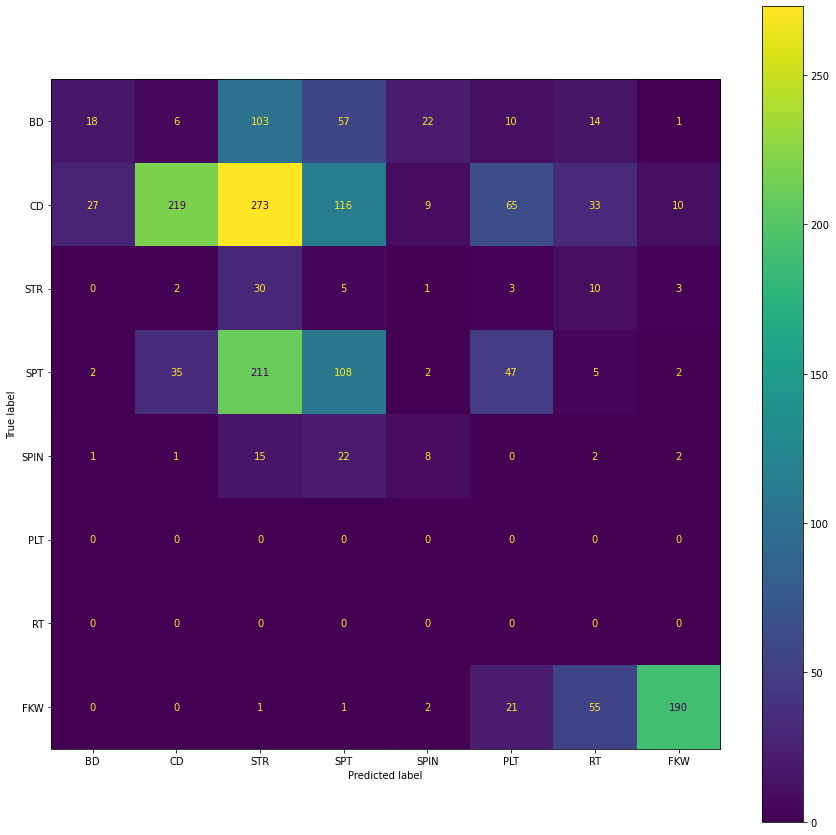

In [59]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


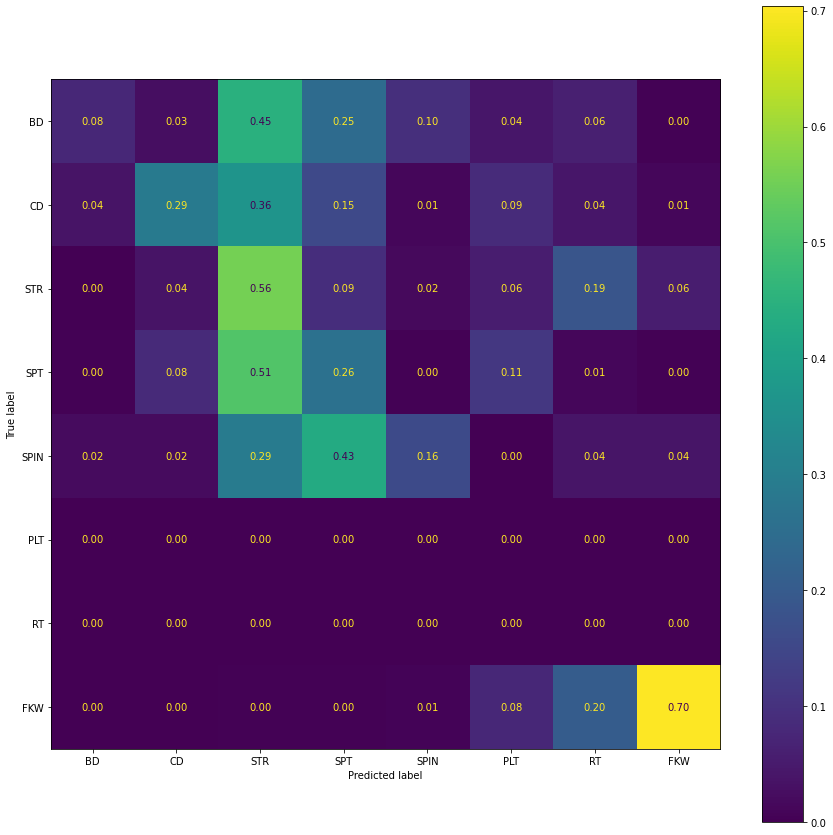

In [60]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## STAR2006

In [61]:
ee = deployment[2]
print(ee)

STAR2006


In [62]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [63]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [64]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [65]:
fea_train = fea_train[:,:100,:]

In [66]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [67]:
Counter(label_train_list)

Counter({'BD': 11466,
         'CD': 28296,
         'PLT': 8250,
         'RT': 7590,
         'SPIN': 6198,
         'SPT': 12744,
         'STR': 10692,
         'FKW': 13662})

In [68]:
Counter(label_test.tolist())

Counter({1.0: 24, 7.0: 903, 5.0: 632, 6.0: 46, 4.0: 2, 3.0: 147, 2.0: 750})

In [69]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [70]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (98898, 100, 128)
feature test shape: (2504, 100, 128)
label train shape: (98898,)
label test shape: (2504,)
dim_time: 100
dim_freq: 128


In [71]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [72]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [73]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [74]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.10, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [75]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_conv_lstm(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = CategoricalCrossentropy()
loss = binary_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

Epoch 1/400
1390/1390 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.2644
Epoch 00001: val_accuracy improved from -inf to 0.36739, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2006/epoch_01_valloss_0.3088_valacc_0.3674.hdf5
1390/1390 [==============================] - 356s 256ms/step - loss: 0.3444 - accuracy: 0.2644 - val_loss: 0.3088 - val_accuracy: 0.3674
Epoch 2/400
1390/1390 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.4424
Epoch 00002: val_accuracy improved from 0.36739 to 0.46236, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2006/epoch_02_valloss_0.2678_valacc_0.4624.hdf5
1390/1390 [==============================] - 355s 256ms/step - loss: 0.2797 - accuracy: 0.4424 - val_loss: 0.2678 - val_accuracy: 0.4624
Epoch 3/400
1390/1390 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.5016
Ep

KeyboardInterrupt: 

In [76]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.6422
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210322_202847/STAR2006/epoch_53_valloss_0.1953_valacc_0.6422.hdf5


In [77]:
model = load_model(the_best_model)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_12 (Activation)   (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_13 (Activation)   (None, 100, 128, 16)      0   

In [78]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [79]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [80]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  0   0   0   0   0   0   0   0]
 [  6   4   7   0   1   4   2   0]
 [ 72  71 403  79  88  23   9   5]
 [112   0   9   6  19   0   1   0]
 [  0   0   0   1   1   0   0   0]
 [152  22  26   6  26 294  72  34]
 [  6   1   3   0   5   7  20   4]
 [ 14   7  23   6   4  64  45 740]]

[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.25 0.17 0.29 0.   0.04 0.17 0.08 0.  ]
 [0.1  0.09 0.54 0.11 0.12 0.03 0.01 0.01]
 [0.76 0.   0.06 0.04 0.13 0.   0.01 0.  ]
 [0.   0.   0.   0.5  0.5  0.   0.   0.  ]
 [0.24 0.03 0.04 0.01 0.04 0.47 0.11 0.05]
 [0.13 0.02 0.07 0.   0.11 0.15 0.43 0.09]
 [0.02 0.01 0.03 0.01 0.   0.07 0.05 0.82]]


In [81]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

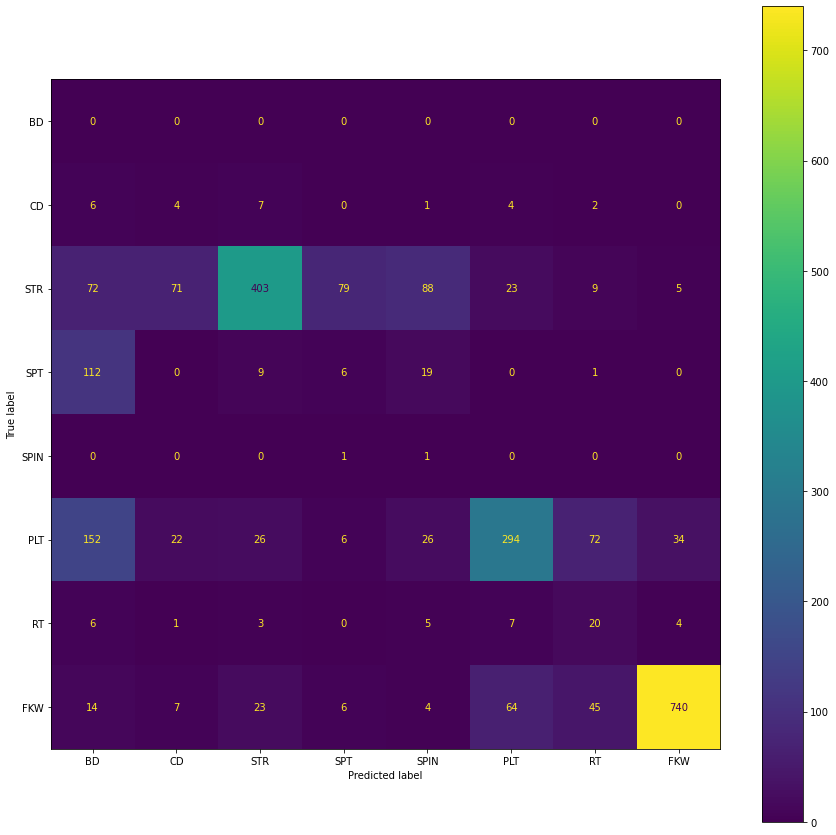

In [82]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


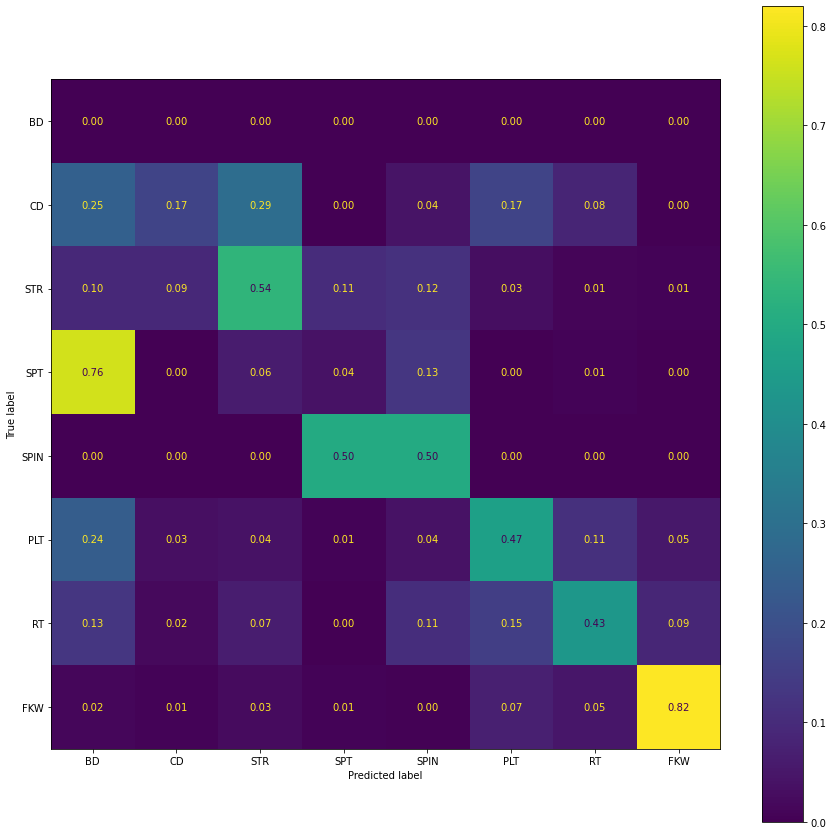

In [83]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## HICEAS2002

In [ ]:
ee = deployment[3]
print(ee)

In [ ]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [ ]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [ ]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [ ]:
fea_train = fea_train[:,:100,:]

In [ ]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [ ]:
Counter(label_train_list)

In [ ]:
Counter(label_test.tolist())

In [ ]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [ ]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

In [ ]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [ ]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [ ]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [ ]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.10, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [ ]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_conv_lstm(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = CategoricalCrossentropy()
loss = binary_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

In [ ]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

In [ ]:
model = load_model(the_best_model)
model.summary()

In [ ]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [ ]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [ ]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

In [ ]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


In [ ]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## PICES2005

In [ ]:
ee = deployment[4]
print(ee)

In [ ]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [ ]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [ ]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [ ]:
fea_train = fea_train[:,:100,:]

In [ ]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [ ]:
Counter(label_train_list)

In [ ]:
Counter(label_test.tolist())

In [ ]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [ ]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

In [ ]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [ ]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [ ]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [ ]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.10, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [ ]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_conv_lstm(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = CategoricalCrossentropy()
loss = binary_crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

In [ ]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

In [ ]:
model = load_model(the_best_model)
model.summary()

In [ ]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [ ]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [ ]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

In [ ]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


In [ ]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)